In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.stats
from pathos.threading import ThreadPool as Pool

from scipy.optimize import leastsq
import scipy.stats as spst
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from f_statistics import *
from f_preprocessing import *
# from f_figures import *
# from f_run_evaluation import *
# from f_effective_cover import *
from f_significance_calculation import *


In [4]:
fol='/home/vanoorschot/work/fransje'

In [5]:
#select index of lat lon points
def select_point(fc,lat_min,lat_max,lon_min,lon_max):
    lat = fc.lat.values
    lon = fc.lon.values
    lat_ix = np.where((lat>lat_min) & (lat<lat_max))[0][0]
    lon_ix = np.where((lon>lon_min) & (lon<lon_max))[0][0]
    latstr = str(np.round(fc.lat[lat_ix].values,3))
    lonstr = str(np.round(fc.lon[lon_ix].values,3)) 
    return lat_ix,lon_ix,latstr,lonstr

In [6]:
from matplotlib.colors import LinearSegmentedColormap
colors =['gainsboro','gainsboro','gainsboro']
cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)
colors2 =['white','white','white']
cmap_white = LinearSegmentedColormap.from_list('cm',colors2, N=3)

In [7]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

## feedback check

In [8]:
# cmap = cm.get_cmap('GnBu_r', 14)
# color_list2 = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# cmap = cm.get_cmap('OrRd', 15)
# color_list4 = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

# whites = ['#ffffff', '#ffffff', '#ffffff', '#ffffff', '#ffffff', '#ffffff', '#ffffff', '#ffffff', '#ffffff', '#ffffff']
# b = color_list2[-1]
# blue = [b,b,b,b,b]
# r = color_list4[0]
# red = [r,r,r,r,r]
# a=np.concatenate([color_list2,whites,whites,color_list4])
# cmap_t = ListedColormap(a)


cmap = cm.get_cmap('GnBu_r', 14)
color_list2 = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

cmap = cm.get_cmap('OrRd', 15)
color_list4 = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

whites = ['#ffffff', '#ffffff', '#ffffff', '#ffffff']
whites1 = [color_list2[-3],color_list2[-3],color_list2[-3],color_list2[-3],color_list2[-3]]
whites2 = [color_list4[2],color_list4[2],color_list4[2],color_list4[2]]
b = color_list2[-1]
blue = [b,b,b,b,b]
r = color_list4[0]
red = [r,r,r,r,r]
color_list2[-1] = color_list2[-3]
color_list2[-2] = color_list2[-3]
color_list4[0] = color_list4[2]
color_list4[1] = color_list4[2]
color_list4[2] = color_list4[2]
color_list4[3] = color_list4[2]
a=np.concatenate([color_list2,whites1,whites2,color_list4])
cmap_t = ListedColormap(a)

In [9]:
cmap = cm.get_cmap('RdBu_r', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_list[10] = '#ffffff'
color_list[11] = '#ffffff'
color_list[12] = '#ffffff'
cmap_rdbu1 = ListedColormap(color_list[0:12])

In [10]:
cmap = cm.get_cmap('Spectral_r', 42)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
# color_list[19] = '#ffffff'
color_list[20] = '#ffffff'
color_list[21] = '#ffffff'
color_list[22] = '#ffffff'
cmap_rdbu1 = ListedColormap(color_list[0:22])

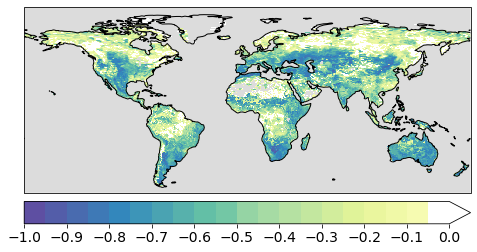

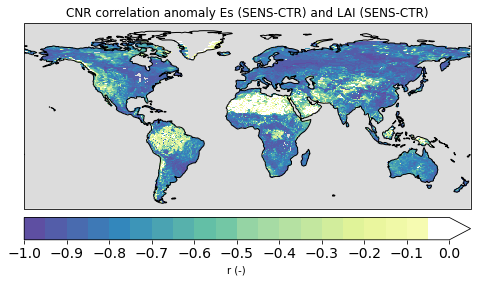

In [11]:
# ES vs SMS
# model
exp_name1='exp3'
exp_name2='exp6'
start_year=1999
end_year=2018

f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
smd = sm12-sm11

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es1 = mod1.ESOIL *-1000
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es2 = mod2.ESOIL *-1000
esd = es2-es1

# correlation
r = xr.corr(smd,esd,dim=['time'])

lvls = np.linspace(-1,0,21)
lvls2 = np.linspace(-1,0,11)

n = es1[0].notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf = r.plot(ax=ax, cmap=cmap_rdbu1, add_colorbar=False, vmin=-1, vmax=0.2,levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02,ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
# ax.set_title(f'CNR correlation anomaly Es (SENS-CTR) and SMs (SENS-CTR)')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/exp3_exp6/global_maps/correlation_Esd_SMsd_anomaly.jpg',dpi=300,bbox_inches='tight')


# CNR
mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_veg_{start_year}_{end_year}_ia_anomalies.nc')
l1 = mod1.var66 #* 0.07 * 1e3 # 7cm
h1 = mod1.var67
lai1 = l1+h1
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_veg_{start_year}_{end_year}_ia_anomalies.nc')
l2 = mod2.var66 #* 0.07 * 1e3 # 7cm
h2 = mod2.var67
lai2 = l2+h2
laid = lai2-lai1

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es1 = mod1.ESOIL *-1000
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es2 = mod2.ESOIL *-1000
esd = es2-es1

# correlation
r = xr.corr(laid,esd,dim=['time'])

lvls = np.linspace(-1,0,21)
lvls2 = np.linspace(-1,0,11)

n = es1[0].notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf = r.plot(ax=ax, cmap=cmap_rdbu1, add_colorbar=False, vmin=-1, vmax=0.2,levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'r (-)', pad=0.02,ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
ax.set_title(f'CNR correlation anomaly Es (SENS-CTR) and LAI (SENS-CTR)')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/exp3_exp6/global_maps/correlation_laid_Esd_anomaly.jpg',dpi=300,bbox_inches='tight')


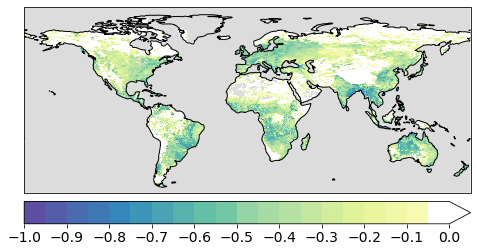

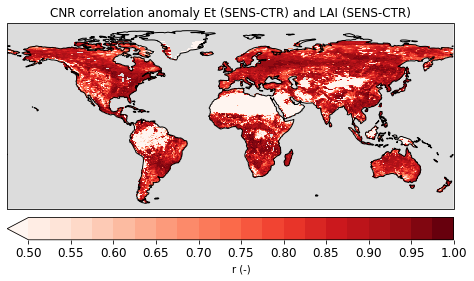

In [12]:
# CNR
cmap=cm.get_cmap('RdBu_r', 21)
# model
exp_name1='exp3'
exp_name2='exp6'
start_year=1999
end_year=2018

f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm11 = mod1.SWVL234 #* 0.07 * 1e3 # 7cm
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm12 = mod2.SWVL234 #* 0.07 * 1e3 # 7cm
smd = sm12-sm11

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es1 = mod1.TVEG *-1000
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es2 = mod2.TVEG *-1000
esd = es2-es1

# correlation
r = xr.corr(smd,esd,dim=['time'])

lvls = np.linspace(-1,0,21)
lvls2 = np.linspace(-1,0,11)

n = es1[0].notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf = r.plot(ax=ax, cmap=cmap_rdbu1, add_colorbar=False, vmin=-1, vmax=0.2,levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02,ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
# ax.set_title(f'CNR correlation anomaly Et (SENS-CTR) and SMsb (SENS-CTR)')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/exp3_exp6/global_maps/correlation_Etd_SMsbd_anomaly.jpg',dpi=300,bbox_inches='tight')


# CNR
mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_veg_{start_year}_{end_year}_ia_anomalies.nc')
l1 = mod1.var66 #* 0.07 * 1e3 # 7cm
h1 = mod1.var67
lai1 = l1+h1
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_veg_{start_year}_{end_year}_ia_anomalies.nc')
l2 = mod2.var66 #* 0.07 * 1e3 # 7cm
h2 = mod2.var67
lai2 = l2+h2
laid = lai2-lai1

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es1 = mod1.TVEG *-1000
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es2 = mod2.TVEG *-1000
esd = es2-es1

# correlation
r = xr.corr(laid,esd,dim=['time'])
cmap=cm.get_cmap('Reds', 21)

lvls = np.linspace(0.5,1,21)
lvls2 = np.linspace(0.5,1,11)

n = es1[0].notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf = r.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=-1, vmax=0.2,levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'r (-)', pad=0.02,ticks=lvls2)
cbar.ax.tick_params(labelsize=12)
ax.set_title(f'CNR correlation anomaly Et (SENS-CTR) and LAI (SENS-CTR)')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/exp3_exp6/global_maps/correlation_Etd_laid_anomaly.jpg',dpi=300,bbox_inches='tight')


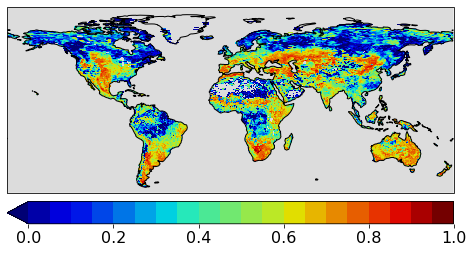

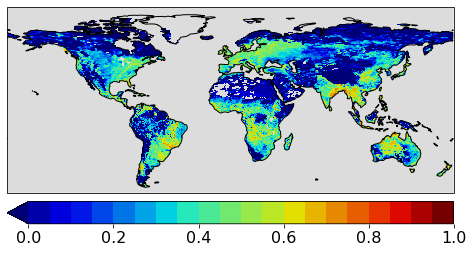

In [14]:
# ES vs SMS
cmap_rdbu1 = cmap_map(lambda x: x/1.1, cm.jet)
# model
exp_name1='exp3'
exp_name2='exp6'
start_year=1999
end_year=2018

f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
smd = sm12-sm11

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es1 = mod1.ESOIL *-1000
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es2 = mod2.ESOIL *-1000
esd = es2-es1

# correlation
r = xr.corr(smd,esd,dim=['time'])
r = r*-1

lvls = np.linspace(0,1,21)
lvls2 = np.linspace(0,1,6)

n = es1[0].notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf = r.plot(ax=ax, cmap=cmap_rdbu1, add_colorbar=False, vmin=-1, vmax=0.2,levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02,ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
# ax.set_title(f'CNR correlation anomaly Es (SENS-CTR) and SMs (SENS-CTR)')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/exp3_exp6/global_maps/correlation_Esd_SMsd_anomaly.jpg',dpi=300,bbox_inches='tight')



# CNR
cmap=cm.get_cmap('RdBu_r', 21)
# model
exp_name1='exp3'
exp_name2='exp6'
start_year=1999
end_year=2018

f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm11 = mod1.SWVL234 #* 0.07 * 1e3 # 7cm
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm12 = mod2.SWVL234 #* 0.07 * 1e3 # 7cm
smd = sm12-sm11

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es1 = mod1.TVEG *-1000
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es2 = mod2.TVEG *-1000
esd = es2-es1

# correlation
r = xr.corr(smd,esd,dim=['time'])
r = r*-1

lvls = np.linspace(0,1,21)
lvls2 = np.linspace(0,1,6)

n = es1[0].notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf = r.plot(ax=ax, cmap=cmap_rdbu1, add_colorbar=False, vmin=-1, vmax=0.2,levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02,ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
# ax.set_title(f'CNR correlation anomaly Et (SENS-CTR) and SMsb (SENS-CTR)')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/exp3_exp6/global_maps/correlation_Etd_SMsbd_anomaly.jpg',dpi=300,bbox_inches='tight')


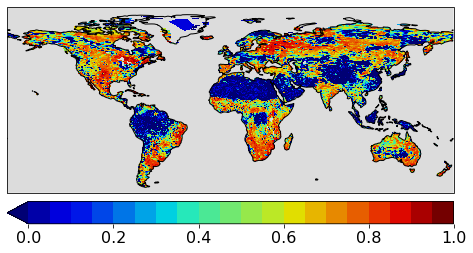

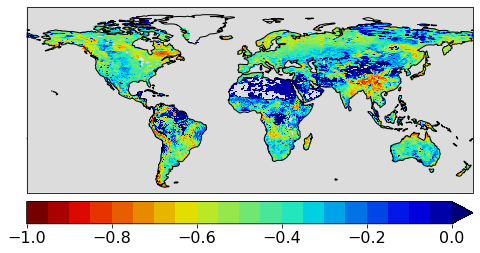

In [14]:
# LOOK UP TABLE
cmap_rdbu1 = cmap_map(lambda x: x/1.1, cm.jet)
# model
exp_name1='exp1'
exp_name2='exp9'
start_year=1999
end_year=2018

f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm11 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm12 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm
smd = sm12-sm11

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es1 = mod1.ESOIL *-1000
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es2 = mod2.ESOIL *-1000
esd = es2-es1

# correlation
r = xr.corr(smd,esd,dim=['time'])

lvls = np.linspace(0,1,21)
lvls2 = np.linspace(0,1,6)

n = es1[0].notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf = r.plot(ax=ax, cmap=cmap_rdbu1, add_colorbar=False, vmin=-1, vmax=0.2,levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02,ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
# ax.set_title(f'CNR correlation anomaly Es (SENS-CTR) and SMs (SENS-CTR)')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/exp1_exp9/global_maps/correlation_Esd_SMsd_anomaly.jpg',dpi=300,bbox_inches='tight')



# CNR
cmap_rdbu1 = cmap_map(lambda x: x/1.1, cm.jet_r)

# model
exp_name1='exp1'
exp_name2='exp9'
start_year=1999
end_year=2018

f_mod1 = f'{fol}/htessel_output/{exp_name1}'
f_mod2 = f'{fol}/htessel_output/{exp_name2}'

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm11 = mod1.SWVL234 #* 0.07 * 1e3 # 7cm
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
sm12 = mod2.SWVL234 #* 0.07 * 1e3 # 7cm
smd = sm12-sm11

mod1 = xr.open_dataset(f'{f_mod1}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es1 = mod1.TVEG *-1000
mod2 = xr.open_dataset(f'{f_mod2}/ia_anomalies/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
es2 = mod2.TVEG *-1000
esd = es2-es1

# correlation
r = xr.corr(smd,esd,dim=['time'])

lvls = np.linspace(-1,0,21)
lvls2 = np.linspace(-1,0,6)

n = es1[0].notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf = r.plot(ax=ax, cmap=cmap_rdbu1, add_colorbar=False, vmin=-1, vmax=0.2,levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02,ticks=lvls2)
cbar.ax.tick_params(labelsize=16)
# ax.set_title(f'CNR correlation anomaly Et (SENS-CTR) and SMsb (SENS-CTR)')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'/home/vanoorschot/work/fransje/scripts/HTESSEL/figures/paper_figures/exp1_exp9/global_maps/correlation_Etd_SMsbd_anomaly.jpg',dpi=300,bbox_inches='tight')
